<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

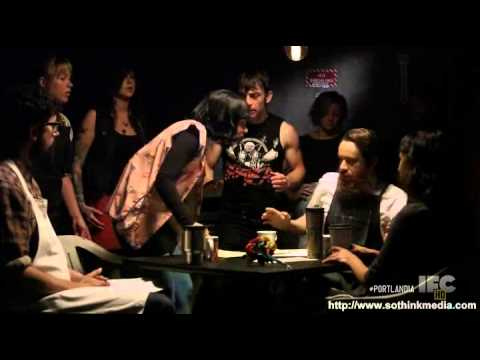

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/content'

In [3]:
import pandas as pd
import string

url = ('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/'
'master/module1-text-data/data/yelp_coffeeshop_review_data.csv')

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [4]:
shops.dtypes

coffee_shop_name    object
full_review_text    object
star_rating         object
dtype: object

In [0]:
df = shops.copy()
df['star_rating'] = shops['star_rating'].str.slice(stop=2).astype(int)

In [0]:
df[['review_date', 'full_review_text']] = shops['full_review_text'].str.split(n=1, expand=True)

In [0]:
check_ins = df['full_review_text'].str.split(pat=r' check-in[s]?', n=2, expand=True)[0]
df['check_ins'] = check_ins * check_ins.str.isdigit()

In [8]:
df['check_ins'][df['check_ins']==''] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
# Convert column for number of check-ins from string to int.
df['check_ins'] = df['check_ins'].astype(int)

In [0]:
# Remove check-ins string, if any.
df['full_review_text'] = df['full_review_text'].str.replace(r'^\d+ check-in[s]? ', '')

In [0]:
# Remove punctuation.
df['full_review_text'] = df['full_review_text'].str.replace('[{}]'.format(string.punctuation), '')

In [0]:
# Reduce any excess whitespace to a single space per instance.
df['full_review_text'] = df['full_review_text'].str.replace(r'\s+', ' ')

In [0]:
# Merge negations with following word.
df['full_review_text'] = df['full_review_text'].str.replace('n\'t ', ' not')
df['full_review_text'] = df['full_review_text'].str.replace(' not ', ' not')

In [0]:
# Make all text lowercase.
df['full_review_text'] = df['full_review_text'].str.lower()

In [0]:
# Differentiate between good and bad reviews.
df['good_review'] = df['star_rating'] > 3

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [0]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [0]:
# Tokenizer Pipe

tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(df['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.lemma_)

    tokens.append(doc_tokens)

df['tokens'] = tokens

In [18]:
df.head()

,coffee_shop_name,full_review_text,star_rating,review_date,check_ins,good_review,tokens
0,The Factory - Cafe With a Soul,love love loved the atmosphere every corner of...,5,11/25/2016,1,True,"[love, love, love, atmosphere, corner, coffee,..."
1,The Factory - Cafe With a Soul,listed in date night austin ambiance in austin...,4,12/2/2016,0,True,"[list, date, night, austin, ambiance, austin, ..."
2,The Factory - Cafe With a Soul,listed in brunch spots i loved the eclectic an...,4,11/30/2016,1,True,"[list, brunch, spot, love, eclectic, homey, pl..."
3,The Factory - Cafe With a Soul,very cool decor good drinks nice seating howev...,2,11/25/2016,0,False,"[cool, decor, good, drink, nice, seat, overpri..."
4,The Factory - Cafe With a Soul,they are located within the northcross mall sh...,4,12/3/2016,1,True,"[locate, northcross, mall, shop, center, face,..."


In [0]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [0]:
good_wc = count(df['tokens'][df['good_review']])

In [21]:
good_wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
32,coffee,3976,8417,1.0,0.029669,0.029669,0.647557
113,place,3133,4816,2.0,0.016976,0.046645,0.510261
77,great,2498,3455,3.0,0.012179,0.058824,0.406840
171,good,2278,3237,4.0,0.011410,0.070234,0.371010
172,like,1665,2401,5.0,0.008463,0.078698,0.271173
8,love,1606,2118,6.0,0.007466,0.086164,0.261564
383,come,1480,1977,7.0,0.006969,0.093132,0.241042
49,austin,1547,1969,8.0,0.006941,0.100073,0.251954
28,shop,1354,1820,9.0,0.006415,0.106488,0.220521
364,time,1331,1766,10.0,0.006225,0.112713,0.216775


In [0]:
bad_wc = count(df['tokens'][~df['good_review']])

In [23]:
bad_wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
32,coffee,948,2170,1.0,0.026793,0.026793,0.642276
0,place,755,1228,2.0,0.015162,0.041955,0.511518
7,like,591,933,3.0,0.011520,0.053475,0.400407
5,good,591,887,4.0,0.010952,0.064427,0.400407
89,order,442,778,5.0,0.009606,0.074033,0.299458
92,come,450,641,6.0,0.007914,0.081947,0.304878
206,time,422,614,7.0,0.007581,0.089528,0.285908
34,drink,365,613,8.0,0.007569,0.097097,0.247290
88,food,316,494,9.0,0.006099,0.103197,0.214092
75,great,336,455,10.0,0.005618,0.108815,0.227642


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [0]:
comp = pd.merge(good_wc[['word', 'appears_in_pct']], bad_wc[['word', 'appears_in_pct']], how='outer', on='word', suffixes = ('_good', '_bad'))

In [25]:
comp.fillna(0)

,word,appears_in_pct_good,appears_in_pct_bad
0,coffee,0.647557,0.642276
1,place,0.510261,0.511518
2,great,0.406840,0.227642
3,good,0.371010,0.400407
4,like,0.271173,0.400407
...,...,...,...
16908,veganhealthy,0.000000,0.000678
16909,overlyoily,0.000000,0.000678
16910,ravi,0.000000,0.000678
16911,uneventful,0.000000,0.000678


In [0]:
comp['diff'] = abs(comp['appears_in_pct_good'] - comp['appears_in_pct_bad'])

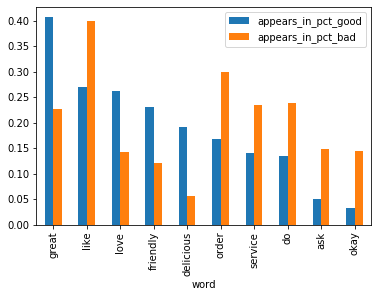

In [27]:
top_10 = comp.sort_values(by='diff', ascending=False).head(10)
top_10.sort_values(by='appears_in_pct_good',
                   ascending=False).plot.bar(x='word',
                                             y=['appears_in_pct_good',
                                                'appears_in_pct_bad']);

In [0]:
five_star_wc = count(df['tokens'][df['star_rating']==5])

In [0]:
one_star_wc = count(df['tokens'][df['star_rating']==1])

In [0]:
comp2 = pd.merge(five_star_wc[['word', 'appears_in_pct']],
                 one_star_wc[['word', 'appears_in_pct']],
                 how='outer',
                 on='word',
                 suffixes = ('_5_star', '_1_star'))

In [0]:
comp2['diff'] = abs(comp2['appears_in_pct_5_star'] - comp2['appears_in_pct_1_star'])

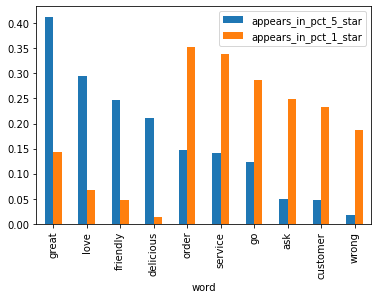

In [32]:
top_10 = comp2.sort_values(by='diff', ascending=False).head(10)
top_10.sort_values(by='appears_in_pct_5_star',
                   ascending=False).plot.bar(x='word',
                                             y=['appears_in_pct_5_star',
                                                'appears_in_pct_1_star']);

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

